In [ ]:
! pip3 install transformers

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

project_dir = './'

In [ ]:
! nvidia-smi

Wed Oct 25 05:58:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
df = pd.read_csv(project_dir + 'full_data.csv')
print(df.shape)
df.head()

(1808, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-5421,"In Spring Framework versions 5.2.0 - 5.2.8, 5....",0,0,0,1,0,1,0,1,0,0,1,0,0,0
1,CVE-2020-5413,Spring Integration framework provides Kryo Cod...,0,0,1,1,0,1,0,0,0,0,0,0,0,0
2,CVE-2020-28035,WordPress before 5.5.2 allows attackers to gai...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CVE-2017-13715,The __skb_flow_dissect function in net/core/fl...,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,CVE-2014-2523,net/netfilter/nf_conntrack_proto_dccp.c in the...,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
tactics = df.columns[2:]
df_filtered = df.drop(df[(df[tactics] == 0).all(axis=1)].index)

df = df_filtered
print(df.shape)

(1718, 16)


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

final_texts = []
final_labels = []

def clean_abstract(text):
    # Replace versions with the word "VERSION"
    version_pattern = r"\d+(\.\d+)+"
    updated_text = re.sub(version_pattern, "version", text)

    # Replace other CVE references
    version_pattern = r'CVE-\d{1,5}-\d{1,5}'
    updated_text = re.sub(version_pattern, "CVE", updated_text)

    return updated_text

def get_texts(df):
    texts = df['Text'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df.iloc[:, 2:].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()
    return ids

texts = get_texts(df)
labels = get_labels(df)
ids = get_ids(df)

for text, label, id in zip(texts[:5], labels[:5], ids):
    print(f'Text -\t{text}')
    print(f'ID -\t{id}')
    print(f'Labels -\t{label}')
    print()

Text -	In Spring Framework versions version - version, version - version, version - version, version - version, and older unsupported versions, the protections against RFD attacks from CVE may be bypassed depending on the browser used through the use of a jsessionid path parameter
ID -	CVE-2020-5421
Labels -	[0 0 0 1 0 1 0 1 0 0 1 0 0 0]

Text -	Spring Integration framework provides Kryo Codec implementations as an alternative for Java (de)serialization. When Kryo is configured with default options, all unregistered classes are resolved on demand. This leads to the "deserialization gadgets" exploit when provided data contains malicious code for execution during deserialization. In order to protect against this type of attack, Kryo can be configured to require a set of trusted classes for (de)serialization. Spring Integration should be proactive against blocking unknown "deserialization gadgets" when configuring Kryo in code
ID -	CVE-2020-5413
Labels -	[0 0 1 1 0 1 0 0 0 0 0 0 0 0]

Tex

## Exploratory Data Analysis

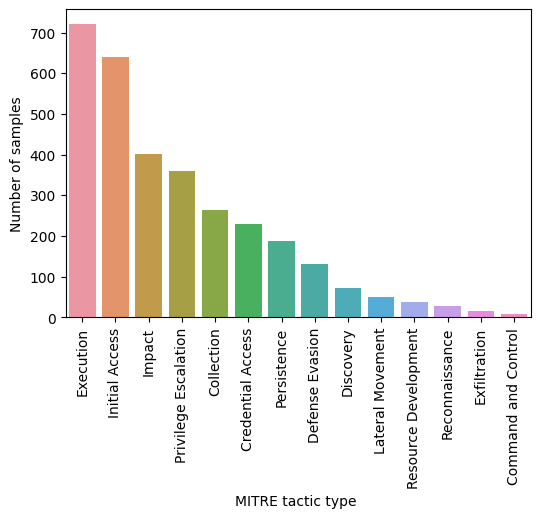

In [ ]:
categories = df.iloc[:, 2:].sum()
plt.figure(figsize=(6, 4))

sorted_categories = categories.sort_values(ascending=False).index
ax = sns.barplot(x=sorted_categories, y=categories[sorted_categories].values)

plt.ylabel('Number of samples')
plt.xlabel('MITRE tactic type ')
plt.xticks(rotation=90)
plt.show()

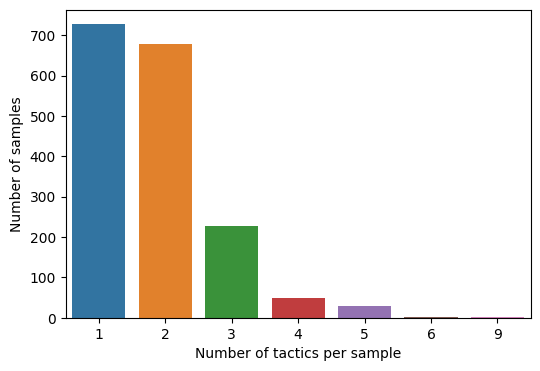

In [ ]:
row_sums = df.iloc[:, 2:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

sorted_counts = multilabel_counts.sort_index()
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=sorted_counts.index, y=sorted_counts.values)

plt.ylabel('Number of samples')
plt.xlabel('Number of tactics per sample')
plt.show()

<BarContainer object of 1718 artists>

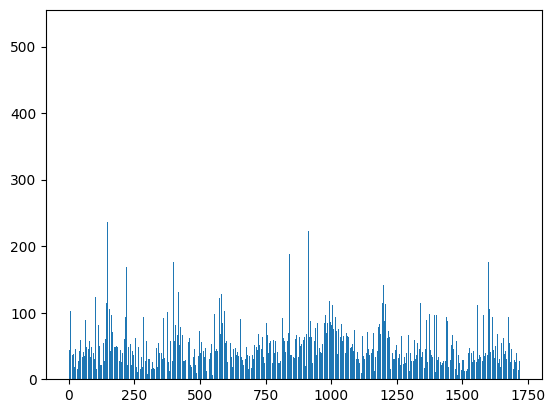

In [ ]:
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

# Config

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM


class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'jenfung/CyBERT-Base-MLM-v1.1'
        self.NUM_LABELS = 14

        self.TOKENIZER = BertTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.20

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 15

config = Config()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Dataset & Dataloader

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

## Train-val Split


In [ ]:
df_train = pd.read_csv(project_dir + 'train_data.csv')
print(df_train.shape)
df_train.head()

(1387, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-15100,"In freewvs before 0.1.1, a user could create a...",0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,CVE-2017-0262,"Microsoft Office 2010 SP2, Office 2013 SP1, an...",0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,CVE-2021-33709,A vulnerability has been identified in Teamcen...,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,CVE-2021-3393,An information leak was discovered in postgres...,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,CVE-2022-26850,When creating or updating credentials for sing...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_test = pd.read_csv(project_dir + 'test_data.csv')
print(df_test.shape)
df_test.head()

(331, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
train_data = TransformerDataset(df_train,  range(len(df_train)))
val_data = TransformerDataset(df_test, range(len(df_test)))

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


# Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
            config.MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, config.NUM_LABELS)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

In [ ]:
device = config.DEVICE
device

device(type='cuda')

# Train and test



In [ ]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  print("Sorted results")
  sorted_results.head()
  return sorted_results.iloc[:, :limit]


def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)

  Y_count = Y.apply(np.sum, axis=0)
  Y_count_sorted = Y_count.sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [ ]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

def val(model, val_dataloader, criterion):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED

    val_loss = 0
    true, pred = [], []

    model.eval()

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true, pred))

    print('Val precision:', precision_score(true, pred, average='weighted'))
    print('Val recall:', recall_score(true, pred, average='weighted'))

    val_micro_f1_score = f1_score(true, pred, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)

    val_macro_f1_score = f1_score(true, pred, average='macro')
    print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    print('Val weighted f1 score:', val_weighted_f1_score)

    if (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)

    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

In [ ]:
def run():
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()

    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'cybert_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

In [ ]:
model = Model()
model.to(device);

Some weights of BertModel were not initialized from the model checkpoint at jenfung/CyBERT-Base-MLM-v1.1 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_model, best_val_weighted_f1_score = run()

Epoch 0:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.6199488128934588
Val accuracy: 0.0513595166163142
Val precision: 0.17000100907066895
Val recall: 0.22009569377990432
Val micro f1 score: 0.2431718061674009
Val macro f1 score: 0.07775761489265316
Val weighted f1 score: 0.15874063229606142


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.36426930866022217
Val loss: 0.3240109994297936
Val accuracy: 0.0
Val precision: 0.0
Val recall: 0.0
Val micro f1 score: 0.0
Val macro f1 score: 0.0
Val weighted f1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: -inf -> 0.0


Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3241247882445653
Val accuracy: 0.0
Val precision: 0.0
Val recall: 0.0
Val micro f1 score: 0.0
Val macro f1 score: 0.0
Val weighted f1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.3114055062847576
Val loss: 0.3008491226605007
Val accuracy: 0.08459214501510574
Val precision: 0.4875585890655425
Val recall: 0.1594896331738437
Val micro f1 score: 0.2638522427440634
Val macro f1 score: 0.07460285983838831
Val weighted f1 score: 0.19905744581530602


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.0 -> 0.19905744581530602


Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.30005972726004465
Val accuracy: 0.09667673716012085
Val precision: 0.4891015417331207
Val recall: 0.1674641148325359
Val micro f1 score: 0.27522935779816515
Val macro f1 score: 0.07933336504765078
Val weighted f1 score: 0.2103499902542965


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.2840281695812598
Val loss: 0.2763205511229379
Val accuracy: 0.1661631419939577
Val precision: 0.634351121779634
Val recall: 0.2886762360446571
Val micro f1 score: 0.4165707710011508
Val macro f1 score: 0.16788285297591252
Val weighted f1 score: 0.3633137814877309


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.19905744581530602 -> 0.3633137814877309


Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2753770621049972
Val accuracy: 0.16314199395770393
Val precision: 0.6246683704817676
Val recall: 0.30462519936204147
Val micro f1 score: 0.43115124153498874
Val macro f1 score: 0.17272075989040683
Val weighted f1 score: 0.37896804947364127


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.254685589294324
Val loss: 0.2749662839231037
Val accuracy: 0.21148036253776434
Val precision: 0.6503789355359392
Val recall: 0.3939393939393939
Val micro f1 score: 0.5056294779938587
Val macro f1 score: 0.24889814101536478
Val weighted f1 score: 0.46858799211859475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.3633137814877309 -> 0.46858799211859475


Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.27593908707300824
Val accuracy: 0.21450151057401812
Val precision: 0.64953873085744
Val recall: 0.3923444976076555
Val micro f1 score: 0.5046153846153846
Val macro f1 score: 0.24864007343353323
Val weighted f1 score: 0.4712453018009721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.23159625972139425
Val loss: 0.26403233125096276
Val accuracy: 0.25075528700906347
Val precision: 0.6109608893626034
Val recall: 0.4864433811802233
Val micro f1 score: 0.5653382761816497
Val macro f1 score: 0.26110082850873345
Val weighted f1 score: 0.5218827681424424


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.46858799211859475 -> 0.5218827681424424


Epoch 5:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.26530749315307256
Val accuracy: 0.2598187311178248
Val precision: 0.6184220303881511
Val recall: 0.48963317384370014
Val micro f1 score: 0.5701021355617455
Val macro f1 score: 0.2682633044321515
Val weighted f1 score: 0.5291169391270438


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.2035637607519654
Val loss: 0.26354742475918363
Val accuracy: 0.2537764350453172
Val precision: 0.6171400684015035
Val recall: 0.5039872408293461
Val micro f1 score: 0.573502722323049
Val macro f1 score: 0.27261175061912485
Val weighted f1 score: 0.5304836149530883


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.5218827681424424 -> 0.5304836149530883


Epoch 6:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2652985794203622
Val accuracy: 0.24773413897280966
Val precision: 0.6095172906150608
Val recall: 0.5167464114832536
Val micro f1 score: 0.5796064400715564
Val macro f1 score: 0.2745042519777653
Val weighted f1 score: 0.5359399717563715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.17828593685709196
Val loss: 0.2682849076532182
Val accuracy: 0.229607250755287
Val precision: 0.6000461782193502
Val recall: 0.48484848484848486
Val micro f1 score: 0.5572868927589367
Val macro f1 score: 0.26296464578323664
Val weighted f1 score: 0.5164468118380721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2689481310191609
Val accuracy: 0.2326283987915408
Val precision: 0.6000613749422287
Val recall: 0.49760765550239233
Val micro f1 score: 0.5662431941923776
Val macro f1 score: 0.26512621106267503
Val weighted f1 score: 0.5217597654896221


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.1574805403749148
Val loss: 0.2800606276307787
Val accuracy: 0.24471299093655588
Val precision: 0.6041712855524919
Val recall: 0.529505582137161
Val micro f1 score: 0.5789014821272885
Val macro f1 score: 0.2951567528513254
Val weighted f1 score: 0.5418321357680778


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.5304836149530883 -> 0.5418321357680778


Epoch 8:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2793398691075189
Val accuracy: 0.24471299093655588
Val precision: 0.598659712804544
Val recall: 0.5279106858054227
Val micro f1 score: 0.5751520417028672
Val macro f1 score: 0.29276944416713
Val weighted f1 score: 0.5383644806064658


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.14238890740035595
Val loss: 0.2781009454102743
Val accuracy: 0.229607250755287
Val precision: 0.6080998091026986
Val recall: 0.4688995215311005
Val micro f1 score: 0.5541941564561734
Val macro f1 score: 0.26530652554981826
Val weighted f1 score: 0.5156519913981813


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2826039642095566
Val accuracy: 0.229607250755287
Val precision: 0.6026184013911939
Val recall: 0.5039872408293461
Val micro f1 score: 0.5658012533572069
Val macro f1 score: 0.284937230442665
Val weighted f1 score: 0.529750197702387


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.12819433974466105
Val loss: 0.28540635179905666
Val accuracy: 0.19939577039274925
Val precision: 0.5938793885371093
Val recall: 0.43221690590111644
Val micro f1 score: 0.5231660231660232
Val macro f1 score: 0.2637407145603096
Val weighted f1 score: 0.4938815808970497


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.28431613211120876
Val accuracy: 0.2084592145015106
Val precision: 0.6007932781272107
Val recall: 0.4481658692185008
Val micro f1 score: 0.5367717287488062
Val macro f1 score: 0.27085159896896455
Val weighted f1 score: 0.5068462544469182


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.11715413835541956
Val loss: 0.2847152962571099
Val accuracy: 0.19939577039274925
Val precision: 0.5977962006263142
Val recall: 0.44178628389154706
Val micro f1 score: 0.5306513409961686
Val macro f1 score: 0.2686975359045002
Val weighted f1 score: 0.5021505491843988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2849072515964508
Val accuracy: 0.19939577039274925
Val precision: 0.6014085712877455
Val recall: 0.4481658692185008
Val micro f1 score: 0.5362595419847328
Val macro f1 score: 0.27371743148115274
Val weighted f1 score: 0.5072984060560641


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.10836300630679076
Val loss: 0.2870161554643086
Val accuracy: 0.22054380664652568
Val precision: 0.6068840066407577
Val recall: 0.4481658692185008
Val micro f1 score: 0.5377990430622009
Val macro f1 score: 0.2730965362630932
Val weighted f1 score: 0.5096554194541097


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2869259012596948
Val accuracy: 0.22658610271903323
Val precision: 0.6110721133079932
Val recall: 0.4481658692185008
Val micro f1 score: 0.5398655139289146
Val macro f1 score: 0.2752298742958275
Val weighted f1 score: 0.512041710407014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.10227306247100063
Val loss: 0.28638724982738495
Val accuracy: 0.21450151057401812
Val precision: 0.595563083103142
Val recall: 0.4688995215311005
Val micro f1 score: 0.5449490268767377
Val macro f1 score: 0.2835294270600367
Val weighted f1 score: 0.5149435509571187


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.28664118832065943
Val accuracy: 0.21450151057401812
Val precision: 0.5970952184735677
Val recall: 0.46411483253588515
Val micro f1 score: 0.541899441340782
Val macro f1 score: 0.2832806281481572
Val weighted f1 score: 0.5125925168240855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.09768300516338184
Val loss: 0.2873983234167099
Val accuracy: 0.22658610271903323
Val precision: 0.6032389400639364
Val recall: 0.4944178628389155
Val micro f1 score: 0.5651777575205105
Val macro f1 score: 0.2857153484762742
Val weighted f1 score: 0.5283454259737218


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.28740251064300537
Val accuracy: 0.22658610271903323
Val precision: 0.6046616175429519
Val recall: 0.4944178628389155
Val micro f1 score: 0.5656934306569342
Val macro f1 score: 0.2860701261489327
Val weighted f1 score: 0.5289791596154721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.09442764867482514
Val loss: 0.2875154983429682
Val accuracy: 0.22658610271903323
Val precision: 0.609936003643176
Val recall: 0.49282296650717705
Val micro f1 score: 0.5648994515539306
Val macro f1 score: 0.2845333080169996
Val weighted f1 score: 0.5278489237530506


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(BEST_F1)

0.5418321357680778


In [ ]:
y_train_df = df_train.drop(df_train.columns[0:2], axis=1)

In [ ]:
f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, df_test.columns[2:], 14)

Sorted results


In [ ]:
print(f1_best_metrics)

    Impact  Execution  Initial Access  Credential Access  Collection  \
0  0.72956   0.671378        0.627737           0.574713        0.56   

   Privilege Escalation  Persistence  Discovery  Reconnaissance  \
0              0.435644     0.408163      0.125             0.0   

   Resource Development  Defense Evasion  Lateral Movement  \
0                   0.0              0.0               0.0   

   Command and Control  Exfiltration  
0                  0.0           0.0  


In [ ]:
f1_best_metrics.head()

,Impact,Execution,Initial Access,Credential Access,Collection,Privilege Escalation,Persistence,Discovery,Reconnaissance,Resource Development,Defense Evasion,Lateral Movement,Command and Control,Exfiltration
0,0.72956,0.671378,0.627737,0.574713,0.56,0.435644,0.408163,0.125,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import (
    recall_score,
    precision_score
  )

In [ ]:
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, df_test.columns[2:], 14)
recall_best_metrics.head()

Sorted results


,Impact,Initial Access,Collection,Execution,Credential Access,Privilege Escalation,Persistence,Discovery,Reconnaissance,Resource Development,Defense Evasion,Lateral Movement,Command and Control,Exfiltration
0,0.725,0.671875,0.660377,0.659722,0.543478,0.305556,0.27027,0.071429,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, df_test.columns[2:], 14)
precision_best_metrics.head()

Sorted results


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Persistence,Privilege Escalation,Impact,Execution,Credential Access,Initial Access,Discovery,Collection,Reconnaissance,Resource Development,Defense Evasion,Lateral Movement,Command and Control,Exfiltration
0,0.833333,0.758621,0.734177,0.683453,0.609756,0.589041,0.5,0.486111,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, df_test.columns[2:], 14)
acc_best_metrics.head()

Sorted results


,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713,0.244713


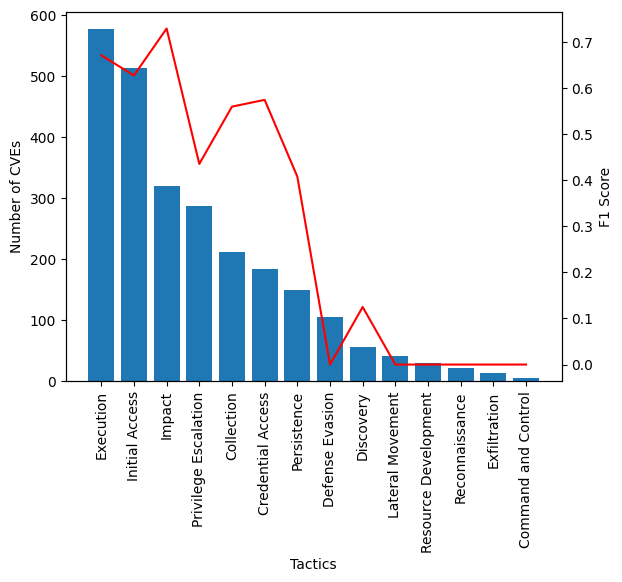

In [ ]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  df_test.columns[2:])